In [71]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [16]:
df = pd.read_excel("../data/processed/BVSP_returns.xlsx")

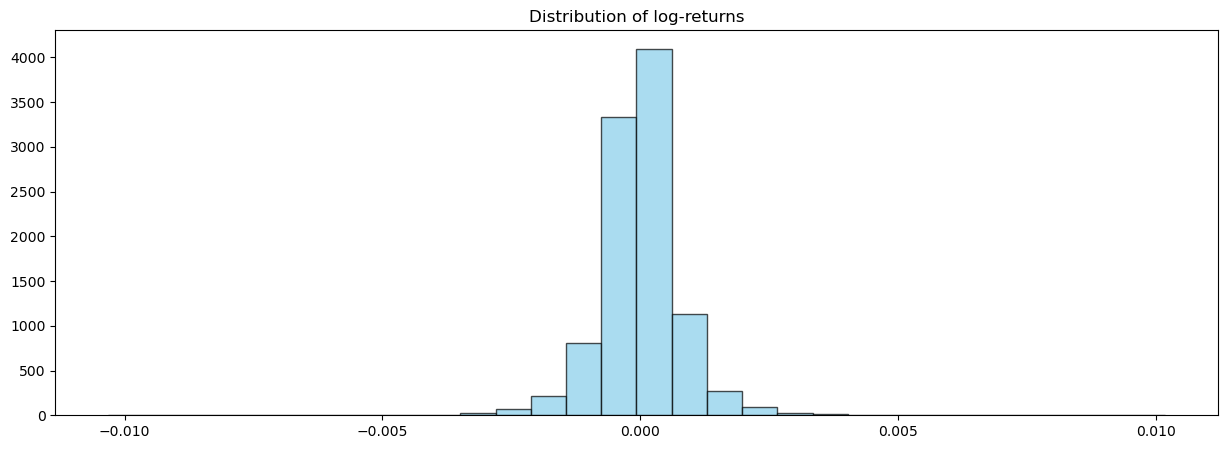

In [70]:
plt.figure(figsize=(15,5))

plt.hist(df["r_t"], bins=30, alpha=0.7, color='skyblue', edgecolor='black')

plt.title("Distribution of log-returns")

plt.show()

In [55]:
# Group by day
grouped = df.groupby(df['datetime'].dt.date)

# Compute KDE per day and store results
kdes = {}
day_index = 1

r_minus_total = []
r_plus_total = []
for day, group in grouped:
    # y variable
    data = group['r_t']
    # kde object
    kde = gaussian_kde(data)
    # support
    r_minus = data.min()
    r_plus = data.max()
    r_minus_total.append(r_minus)
    r_plus_total.append(r_plus)
    # grid
    x_grid = np.linspace(data.min(), data.max(), 200)
    # kde estimation
    y_kde = kde(x_grid)
    # store values
    kdes[day_index] = {
        "x_grid": x_grid,
        "y_kde":  y_kde
        }
    
    day_index += 1

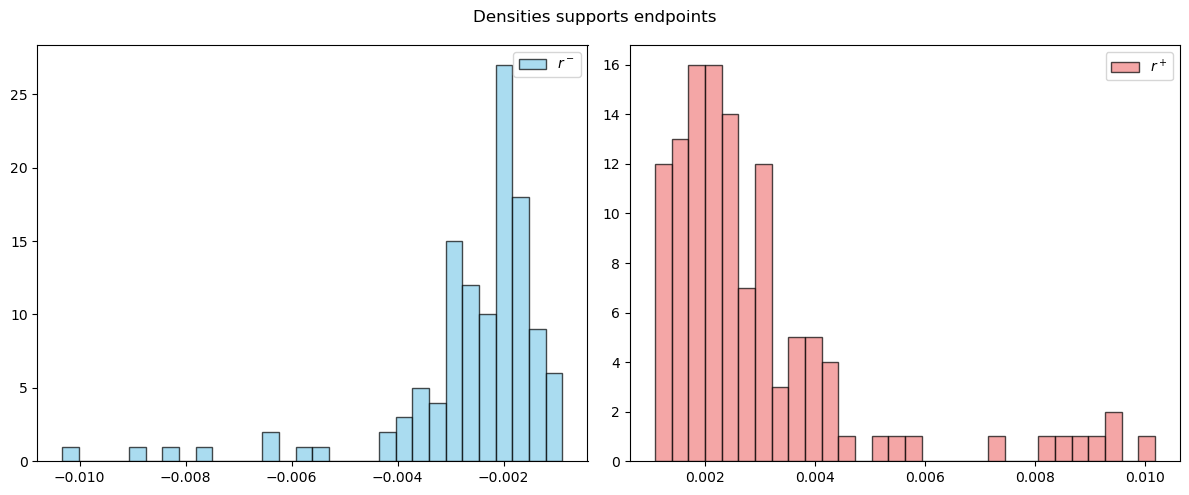

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(r_minus_total, bins=30, alpha=0.7, color='skyblue', edgecolor='black', label="$r^-$")
ax1.legend()

ax2.hist(r_plus_total, bins=30, alpha=0.7, color='lightcoral', edgecolor='black', label="$r^+$")
ax2.legend()

plt.suptitle('Densities supports endpoints')
plt.tight_layout()
plt.show()

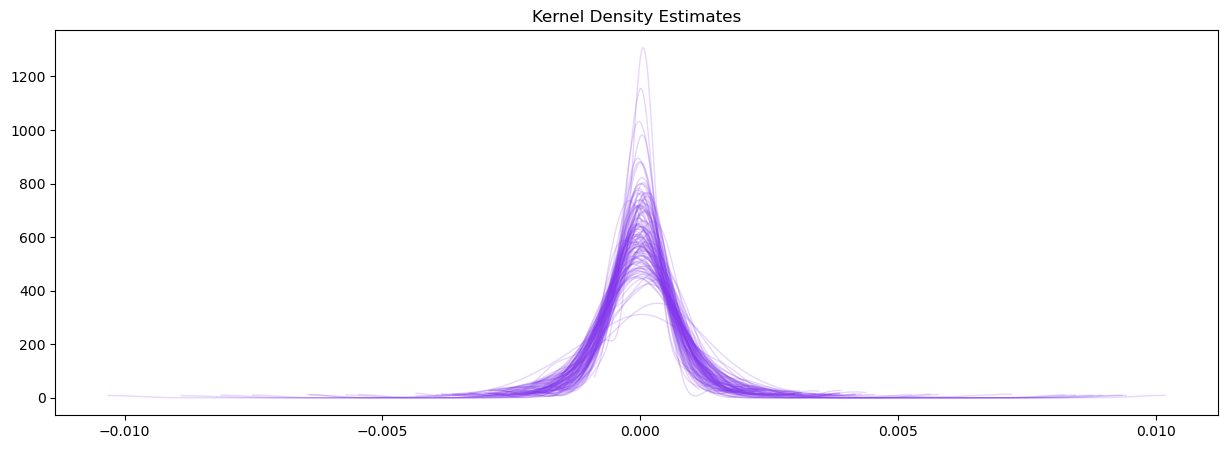

In [65]:
plt.figure(figsize=(15,5))

for day_index in kdes.keys():
    plt.plot(kdes[day_index]["x_grid"], kdes[day_index]["y_kde"], linewidth=1, alpha=.2, c = '#8338ec')

plt.title("Kernel Density Estimates")

plt.show()

In [76]:
# kde_results = {day: (x_grid, y_kde)} from previous step

# Sort days and build aligned matrices
days_sorted = sorted(kdes.keys())

# ---- Step 1: build a common X grid (important for smooth 3D surface)
all_x = np.concatenate([kdes[d]["x_grid"] for d in days_sorted])
x_common = np.linspace(all_x.min(), all_x.max(), 200)

# ---- Step 2: evaluate each day's KDE on the common grid
Z = []
for d in days_sorted:
    kde = kdes[d]["x_grid"]
    density = kdes[d]["y_kde"]
    # Interpolate densities to common x grid
    z_interp = np.interp(x_common, kde, density)
    Z.append(z_interp)

Z = np.array(Z)
Y = np.arange(len(days_sorted))  # day index

# ---- Step 3: create 3D surface
fig = go.Figure(data=[go.Surface(
    x=x_common,   # log return values
    y=Y,          # day index
    z=Z,          # densities
    colorscale='Turbo'
)])

# ---- Step 4: layout and labels
fig.update_layout(
    # title='Daily Kernel Density Estimates of Log Returns',
    scene=dict(
        xaxis_title='Log return',
        yaxis_title='Day',
        zaxis_title='Density',
        yaxis=dict(
            tickmode='array',
            tickvals=np.linspace(0, len(days_sorted)-1, 10, dtype=int),
            ticktext=[str(days_sorted[i]) for i in np.linspace(0, len(days_sorted)-1, 10, dtype=int)]
        )
    ),
    height=700,
    scene_camera=dict(
        eye=dict(x=0.7, y=2.0, z=0.8)  # change these values to rotate
    ),
    title={
        'text': "Daily Kernel Density Estimates of Log Returns",
        'x': 0.5,  # Center horizontally
        'xanchor': 'center'
    }
)


fig.show()